In [1]:
# Import required modules
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Use ggplot
matplotlib.style.use('ggplot')

# Load JSON data into a dictionary
with open('../4_response_extraction/results_dataframe.json', 'r') as file:
    data = json.load(file)

# Convert dictionary to DataFrame
df = pd.DataFrame(data)
df.head()

,model,prompt_method,prompt_template,prompt_short,sample_size,org_folder,file_path,extracted_rows,extracted_data_len,failed_to_capture,regex_counts
0,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.301, 35.0, 1.87, 3.3, 5.12e+20, 5...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
1,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.485, 30.0, 2.36, 3.3, 6.38e+20, 7...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
2,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[aluminium, 0.85, 45.0, 3.2, 3.3, 7.2e+20, 89...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
3,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.3, 35.0, 1.8, 3.3, 5.2e+20, 51000...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
4,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.3, 35.0, 1.8, 3.3, 5.2e+20, 51000...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."


In [2]:
# All models grouped together so 12 models x 15 responses per combination = 180
df_grp_prompt_ss= df.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].count().reset_index()
df_grp_prompt_ss

,prompt_method,sample_size,extracted_data_len
0,chain_of_thought,rs_size_10,180
1,chain_of_thought,rs_size_100,180
2,chain_of_thought,rs_size_150,180
3,chain_of_thought,rs_size_25,165
4,chain_of_thought,rs_size_5,165
...,...,...,...
67,step_back_prompting,rs_size_100,180
68,step_back_prompting,rs_size_150,180
69,step_back_prompting,rs_size_25,180
70,step_back_prompting,rs_size_5,180


In [3]:
# Custom aggregation function to sum dictionary values
def sum_dicts(series):
    result = {}
    for d in series:
        for key, val in d.items():
            if key in result:
                result[key] += val
            else:
                result[key] = val
    return result

# Group by 'model' and aggregate using custom function
result = df.groupby('model')['regex_counts'].agg(sum_dicts).reset_index()

regex_cols = ['multi_pattern', 'list_new_pattern', 'dict_pattern', 
              'row_list_pattern', 'row_key_value_space_pattern', 'dict_equal_val_key_pattern']

# Initialize a new DataFrame
df_regex = pd.DataFrame(columns=['model'] + regex_cols)

# Populate the new DataFrame
rows_list = []
for index, row in result.iterrows():
    # Start by setting the model
    new_row = {'model': row['model']}
    
    # Retrieve the regex_counts dictionary from the result DataFrame
    regex_counts = row['regex_counts']
    
    # Loop through each expected regex column to set its value
    for col in regex_cols:
        new_row[col] = regex_counts.get(col, 0)  # Use .get to avoid KeyError if key is missing
    
    # Add new_row to rows_list to append later
    rows_list.append(new_row)

# Create a DataFrame from rows_list and concatenate with the initial empty DataFrame
df_regex = pd.concat([df_regex, pd.DataFrame(rows_list)], ignore_index=True)

df_regex

,model,multi_pattern,list_new_pattern,dict_pattern,row_list_pattern,row_key_value_space_pattern,dict_equal_val_key_pattern
0,claude-3-5-sonnet-20240620,27590,27620,0,27606,0,0
1,claude-3-sonnet-20240229,25641,26593,0,25650,0,75
2,gemma:7b,1029,1362,823,1202,0,237
3,gpt-3.5-turbo-0125,24673,24924,0,24594,0,15
4,gpt-4o,27295,29143,0,24811,0,398
5,llama2:13b,4255,5797,646,4506,535,782
6,llama3:70b,18677,20352,4,12389,0,7204
7,llama3:8b,14571,15846,88,14155,31,498
8,mistral:7b,4584,6498,70,4670,1,477
9,mixtral:8x22b,20953,21663,164,20729,25,50


                         model  extracted_data_len
0   claude-3-5-sonnet-20240620            1.000000
1     claude-3-sonnet-20240229            0.994667
2           gpt-3.5-turbo-0125            0.973333
3                       gpt-4o            0.933333
4                mixtral:8x22b            0.780000
5                    llama3:8b            0.537333
6                   llama3:70b            0.322667
7             phi3:medium-128k            0.208000
8                   mistral:7b            0.129333
9                     gemma:7b            0.024000
10                  llama2:13b            0.013333
11              phi3:mini-128k            0.002667


/tmp/ipykernel_491979/4202814363.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate the x labels for better readability


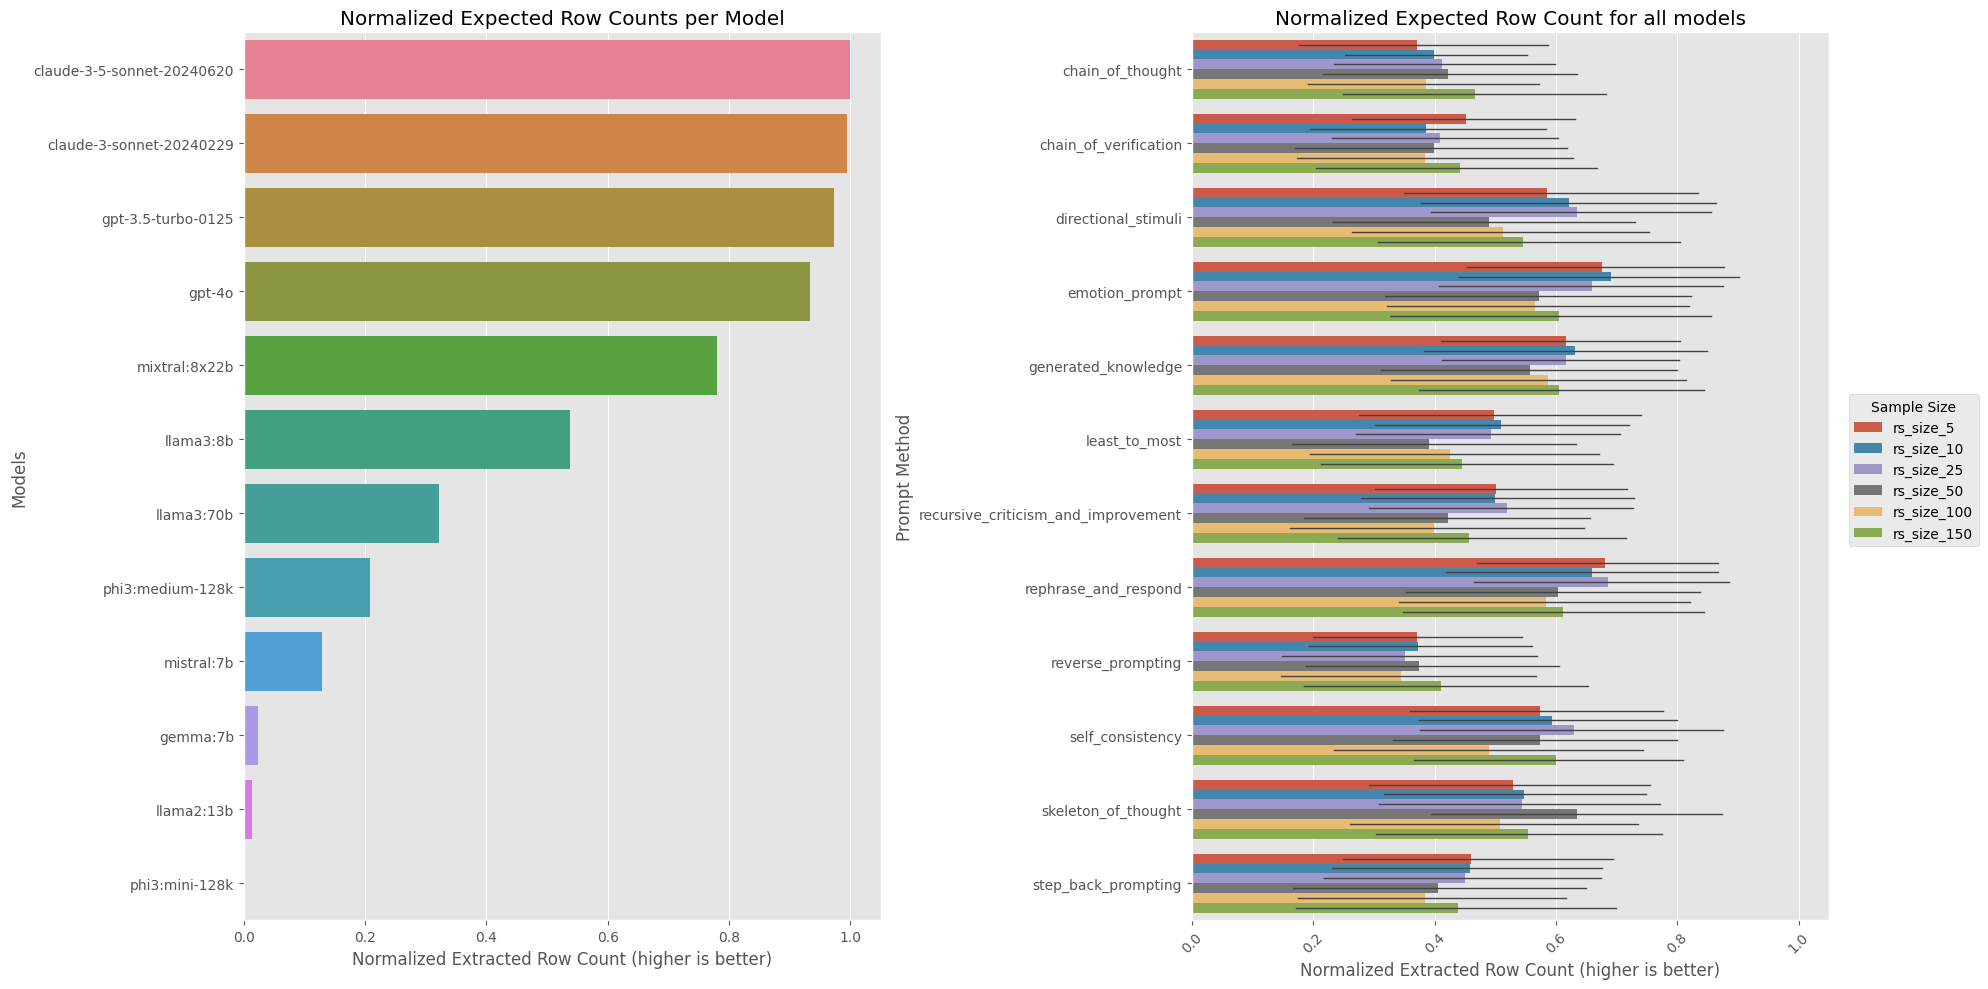

In [4]:
# Assuming df is your DataFrame and all previous calculations are correct
# Calculating normalized expected row count
model_ex_row_norm = df.groupby(['model','prompt_method','sample_size'])['extracted_data_len'].sum() / (15 * 25)
df_model_ex_row_norm = model_ex_row_norm.reset_index()

# Group by model, calculate median and sort descending
model_ex_row_norm_median = model_ex_row_norm.groupby('model').median().sort_values(ascending=False).reset_index()

print(model_ex_row_norm_median)

# Create a proper order for the 'sample_size' column
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the size as needed

# First subplot
sns.barplot(y='model', x='extracted_data_len', data=model_ex_row_norm_median, ax=ax1, hue='model')
ax1.set_title('Normalized Expected Row Counts per Model')
ax1.set_ylabel('Models')
ax1.set_xlim([0,1.05])
ax1.set_xlabel('Normalized Extracted Row Count (higher is better)')

# Second subplot
sns.barplot(data=df_model_ex_row_norm, y='prompt_method', x='extracted_data_len', hue='sample_size', hue_order=sample_size_order, ax=ax2, err_kws={'linewidth': 1})
ax2.set_title('Normalized Expected Row Count for all models')
ax2.set_ylabel('Prompt Method')
ax2.set_xlabel('Normalized Extracted Row Count (higher is better)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate the x labels for better readability
ax2.set_xlim([0,1.05])
ax2.legend(title='Sample Size', bbox_to_anchor=(1.02, 0.6), loc='upper left')  # Adjust legend position

# Tight layout to ensure everything fits without overlap
plt.tight_layout()

plt.savefig('./images/model_overall_performance_vs_prompt_method_performance.jpg', dpi=300)
plt.show()

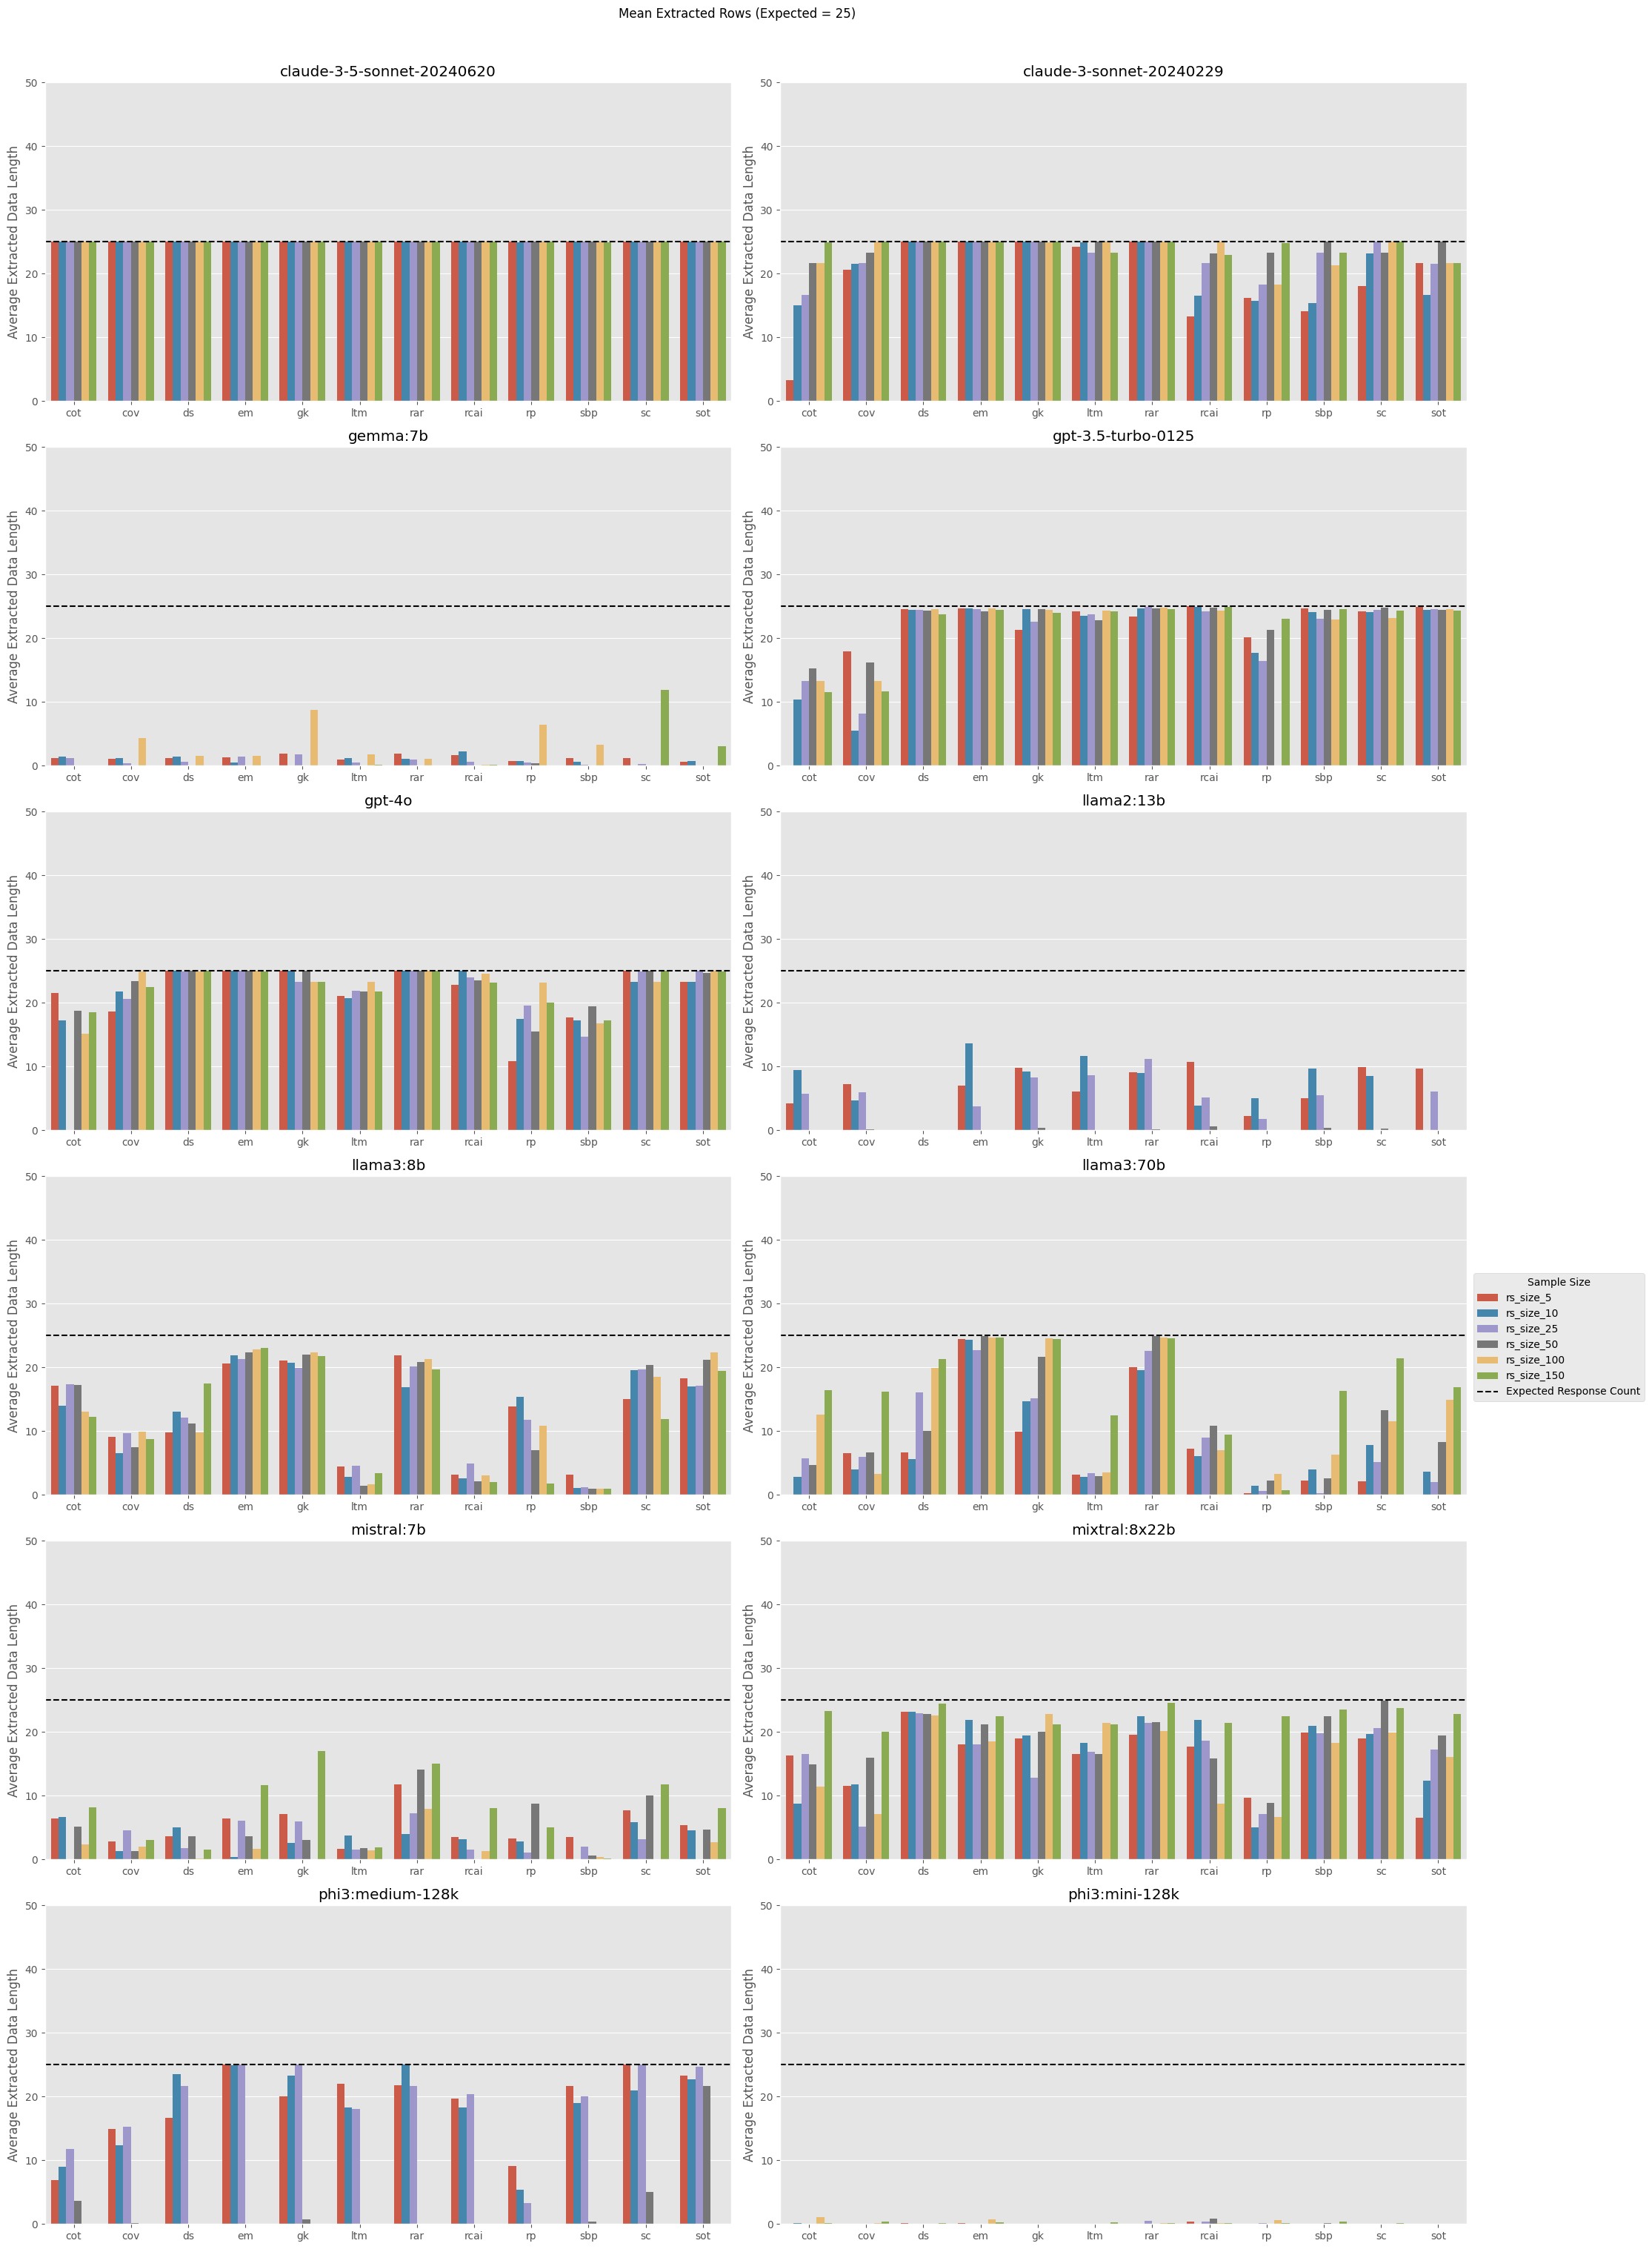

In [5]:
# Identify unique models
unique_models = df['model'].unique()
num_models = len(unique_models)

# Set the order for sample sizes
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']

# Define the expected response count (place your actual expected value here)
expected_response_count = 25

# Create a figure with subplots (two columns)
fig, axes = plt.subplots((num_models + 1) // 2, 2, figsize=(20, 5 * ((num_models + 1) // 2)), squeeze=False)  # Adjust height as needed

for i, model in enumerate(unique_models):
    # Calculate row and column index for the current plot
    row, col = divmod(i, 2)
    
    # Filter data for the current model
    model_data = df[df['model'] == model]
    grouped_data_avg = model_data.groupby(['prompt_short', 'sample_size'])['extracted_data_len'].mean().reset_index()

    # Plotting for the current model
    ax = axes[row][col]  # Get the subplot axis
    sns.barplot(data=grouped_data_avg, x='prompt_short', y='extracted_data_len', hue='sample_size', hue_order=sample_size_order, ax=ax)
    ax.set_title(f'{model}')
    ax.set_xlabel('')
    ax.set_ylabel('Average Extracted Data Length')
    ax.set_ylim([0, 50])
    ax.axhline(y=expected_response_count, color='black', label='Expected Response Count', linestyle='--')  # Vertical line for expected count
    ax.get_legend().remove()

# Adjust layout to prevent overlap and ensure that empty subplots do not show any axis
for ax in axes.flat:
    if not ax.has_data():
        ax.set_visible(False)

plt.suptitle('Mean Extracted Rows (Expected = 25)', y=1.01)
plt.tight_layout()

plt.legend(title='Sample Size', bbox_to_anchor=(1.002, 3), loc='upper left')

plt.savefig('./images/model_comparison_extracted_rows_vertical.jpg', dpi=300, bbox_inches='tight')
plt.show()

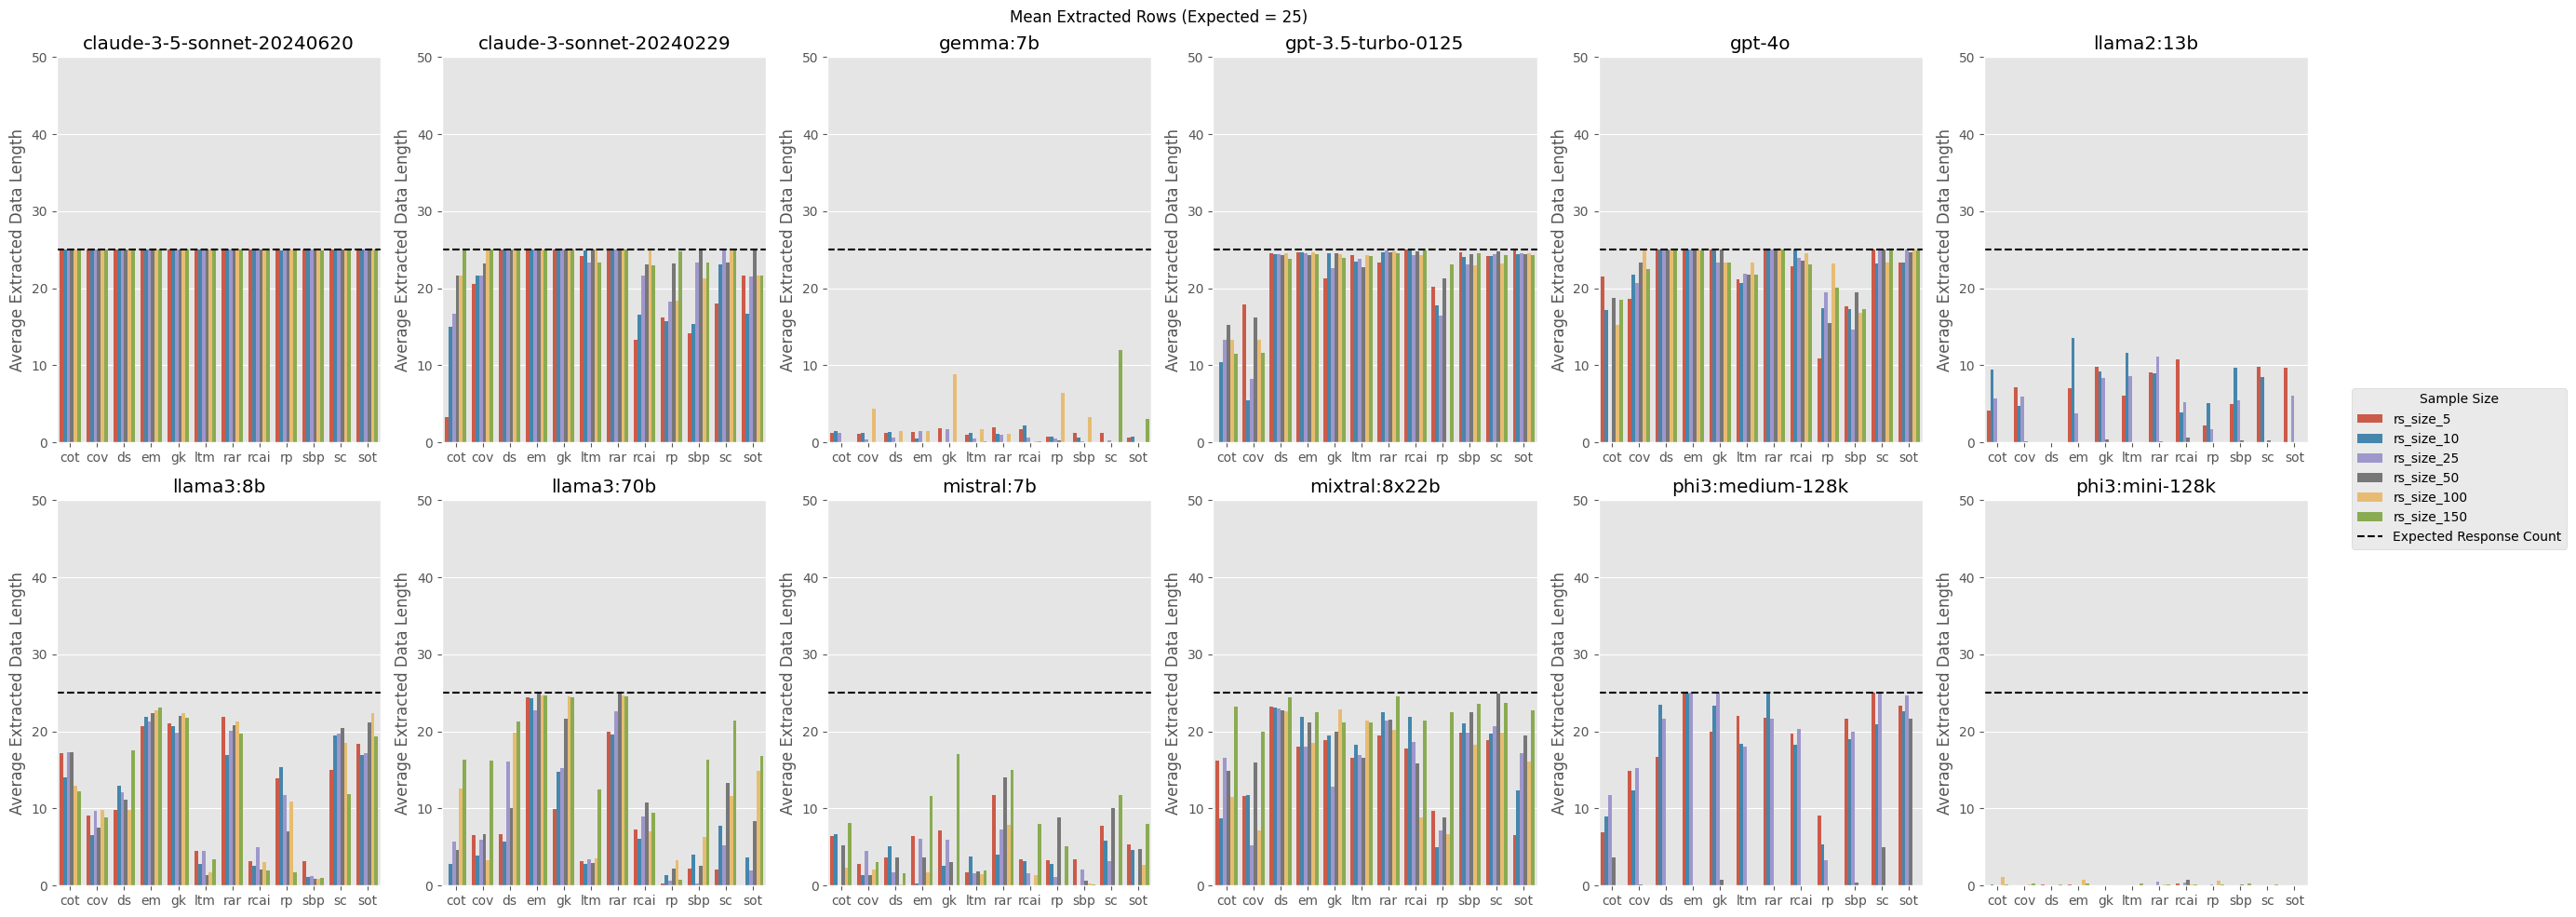

In [6]:
# Identify unique models
unique_models = df['model'].unique()
num_models = len(unique_models)

# Set the order for sample sizes
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']

# Define the expected response count (place your actual expected value here)
expected_response_count = 25

# Create a figure with subplots (2 rows and 5 columns)
fig, axes = plt.subplots(2, 6, figsize=(25, 10), squeeze=False)  # Adjust width and height as needed

for i, model in enumerate(unique_models):
    # Calculate row and column index for the current plot
    row, col = divmod(i, 6)  # Divmod by 5 for 5 plots per row
    
    # Filter data for the current model
    model_data = df[df['model'] == model]
    grouped_data_avg = model_data.groupby(['prompt_short', 'sample_size'])['extracted_data_len'].mean().reset_index()

    # Plotting for the current model
    ax = axes[row][col]  # Get the subplot axis
    sns.barplot(data=grouped_data_avg, x='prompt_short', y='extracted_data_len', hue='sample_size', hue_order=sample_size_order, ax=ax)
    ax.set_title(f'{model}')
    ax.set_xlabel('')
    ax.set_ylabel('Average Extracted Data Length')
    ax.set_ylim([0, 50])
    ax.axhline(y=expected_response_count, color='black', label='Expected Response Count', linestyle='--')  # Horizontal line for expected count
    ax.get_legend().remove()

# Handle legends outside of the subplots
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, title='Sample Size', bbox_to_anchor=(1.01, 0.58), loc='upper left')

plt.suptitle('Mean Extracted Rows (Expected = 25)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure without cropping
plt.savefig('./images/model_comparison_extracted_rows_horizontal.jpg', dpi=300, bbox_inches='tight')
plt.show()


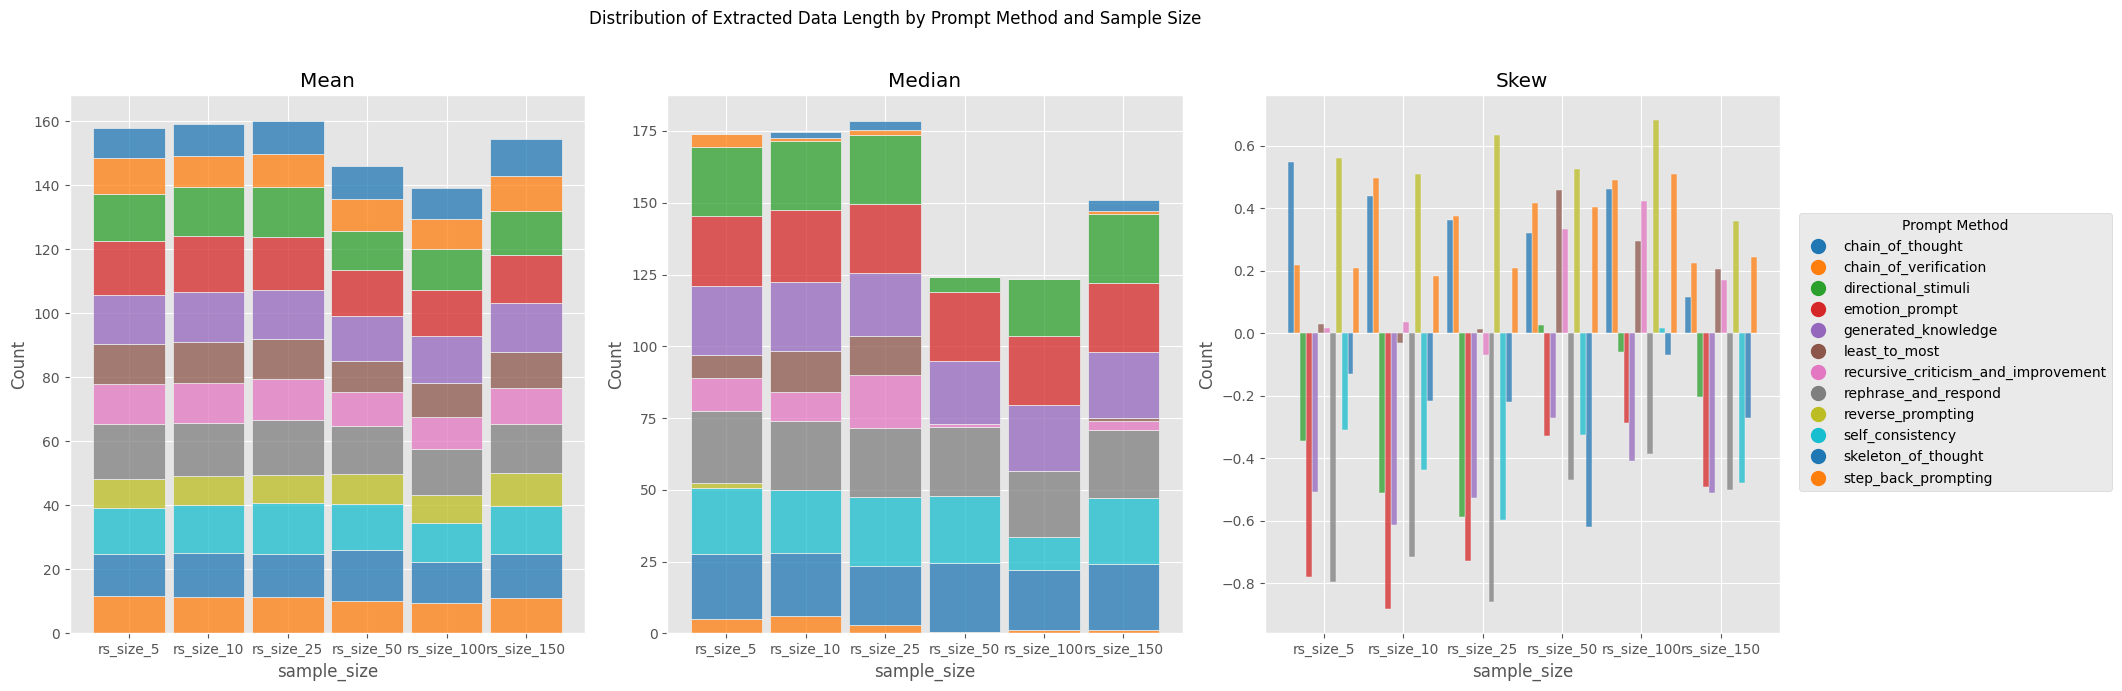

In [7]:
# Assuming 'df' is your initial DataFrame
# Group the data and calculate the statistics
df_copy = df.copy()

grouped_data_mean = df_copy.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].mean().reset_index()
grouped_data_median = df_copy.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].median().reset_index()
grouped_data_skew = df_copy.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].skew().reset_index()

# Define the order of 'sample_size' and 'prompt_method'
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']
prompt_method_order = sorted(grouped_data_mean['prompt_method'].unique())  # Sorted alphabetically

# Convert 'sample_size' to a categorical type with a defined order in all DataFrames
dataframes = [grouped_data_mean, grouped_data_median, grouped_data_skew]
for df_copy in dataframes:
    df_copy['sample_size'] = pd.Categorical(df_copy['sample_size'], categories=sample_size_order, ordered=True)

# Create a figure and array of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
fig.suptitle('Distribution of Extracted Data Length by Prompt Method and Sample Size')

# Color palette
palette = sns.color_palette('tab10', len(prompt_method_order))

# Plot each statistic in its respective subplot
sns.histplot(data=grouped_data_mean, x='sample_size', weights='extracted_data_len', hue='prompt_method',
             hue_order=prompt_method_order, multiple='stack', shrink=0.90, palette=palette, ax=ax1)
ax1.set_title('Mean')
ax1.get_legend().remove()

sns.histplot(data=grouped_data_median, x='sample_size', weights='extracted_data_len', hue='prompt_method',
             hue_order=prompt_method_order, multiple='stack', shrink=0.90, palette=palette, ax=ax2)
ax2.set_title('Median')
ax2.get_legend().remove()

sns.histplot(data=grouped_data_skew, x='sample_size', weights='extracted_data_len', hue='prompt_method',
             hue_order=prompt_method_order, multiple='dodge', shrink=0.90, palette=palette, ax=ax3)
ax3.set_title('Skew')
ax3.get_legend().remove()

# sns.boxplot(data=grouped_data_box, x='sample_size', weights='extracted_data_len', hue='prompt_method',
#              hue_order=prompt_method_order, multiple='stack', shrink=0.90, palette=palette, ax=ax4)
# ax4.set_title('Boxplot')
# ax4.get_legend().remove()

# Create a custom legend
legend_handles = [plt.Line2D([0], [0], color=palette[i], marker='o', linestyle='', markersize=10, label=label) 
                  for i, label in enumerate(prompt_method_order)]
fig.legend(handles=legend_handles, title='Prompt Method', loc='upper right', bbox_to_anchor=(1.18, 0.70), fontsize='medium')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect to fit the figure title and the legend

plt.savefig('./images/stacked_bar_mean_median_max_extracted_rows.jpg', dpi=300)
plt.show()

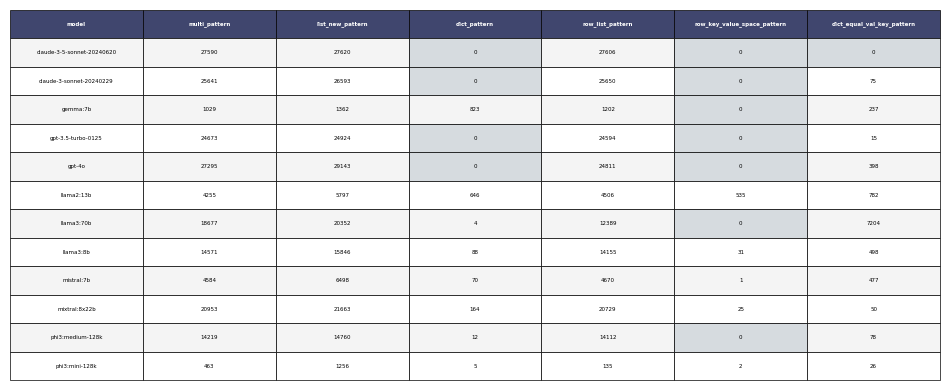

In [8]:
# Custom aggregation function to sum dictionary values
def sum_dicts(series):
    result = {}
    for d in series:
        for key, val in d.items():
            if key in result:
                result[key] += val
            else:
                result[key] = val
    return result

# Group by 'model' and aggregate using custom function
result = df.groupby('model')['regex_counts'].agg(sum_dicts).reset_index()

regex_cols = ['multi_pattern', 'list_new_pattern', 'dict_pattern', 
              'row_list_pattern', 'row_key_value_space_pattern', 'dict_equal_val_key_pattern']

# Initialize a new DataFrame
df_regex = pd.DataFrame(columns=['model'] + regex_cols)

# Populate the new DataFrame
rows_list = []
for index, row in result.iterrows():
    # Start by setting the model
    new_row = {'model': row['model']}
    
    # Retrieve the regex_counts dictionary from the result DataFrame
    regex_counts = row['regex_counts']
    
    # Loop through each expected regex column to set its value
    for col in regex_cols:
        new_row[col] = regex_counts.get(col, 0)  # Use .get to avoid KeyError if key is missing
    
    # Add new_row to rows_list to append later
    rows_list.append(new_row)

# Create a DataFrame from rows_list and concatenate with the initial empty DataFrame
df_regex = pd.concat([df_regex, pd.DataFrame(rows_list)], ignore_index=True)

df_regex

# Plotting setup
# Adjust the figure size dynamically based on the number of rows
fig_height = len(df_regex) * 0.02 + 0.5  # 0.02 per row plus some margin
fig, ax = plt.subplots(figsize=(12, fig_height))  # Use dynamic height
ax.axis('off')  # Hide the axis

# Create the table
the_table = ax.table(cellText=df_regex.values, colLabels=df_regex.columns, loc='center', cellLoc='center', colColours=["#f2f2f2"] * len(df_regex.columns))

# Customize cell properties for aesthetics
for (i, j), cell in the_table.get_celld().items():
    text = cell.get_text().get_text()  # Get cell text
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)  # Bold headers
        cell.set_facecolor('#40466e')  # Darker color for header
        cell.set_text_props(color='white')  # White text for contrast
    else:
        if text == '0':  # Check if cell text is '0'
            cell.set_facecolor('#d6dbdf')  # Set dark grey for zero values
        else:
            cell.set_facecolor('#f4f4f4' if i % 2 else 'white')  # Alternating colors for non-zero rows
    cell.set_height(0.5)  # Increased height for all cells

# Optionally, save the figure
plt.savefig('./images/table_regex_performance.jpg', dpi=300, bbox_inches='tight')
plt.show()
